In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score

import time

from idlmam import train_network, Flatten, weight_reset, View, set_seed

In [ ]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

<ipython-input-2-475911aa0aa9>:3: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('png', 'pdf')


In [ ]:
torch.backends.cudnn.deterministic=True
set_seed(42)

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
mnist_train = torchvision.datasets.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
mnist_test = torchvision.datasets.MNIST("./", train=False, transform=transforms.ToTensor(), download=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16029233.14it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 488493.71it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4462628.38it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 9283883.42it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
class LargestDigit(Dataset):
    """
    Creates a modified version of a dataset where some number of samples are taken,
    and the true label is the largest label sampled. When used with MNIST the labels
    correspond to their values (e.g., digit "6" has label 6)
    """

    def __init__(self, dataset, toSample=3):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.toSample = toSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        #Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0,len(self.dataset), size=self.toSample)

        #Stack the n items of shape (B, *) shape into (B, n, *)
        x_new = torch.stack([self.dataset[i][0] for i in selected])
        #Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        #Return (data, label) pair!
        return x_new, y_new

In [ ]:
B = 128
epochs = 10

largest_train = LargestDigit(mnist_train)
largest_test = LargestDigit(mnist_test)

train_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
test_loader = DataLoader(largest_test, batch_size=B)

In [ ]:
#Want a consistent dataset split
set_seed(34)

True Label is =  8


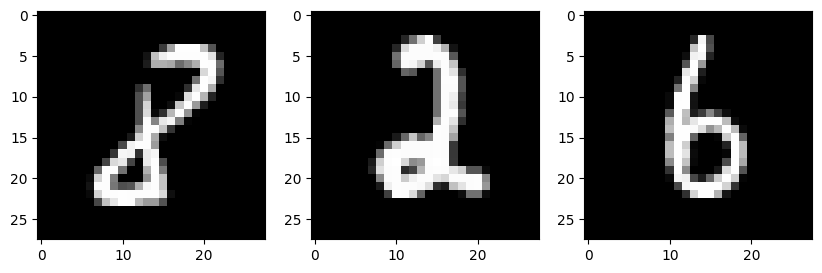

In [ ]:
x, y = largest_train[0]

f, axarr = plt.subplots(1,3, figsize=(10,10))
for i in range(3):
    axarr[i].imshow(x[i,0,:].numpy(), cmap='gray', vmin=0, vmax=1)
print("True Label is = ", y)

The neural network described can be formulated mathematically as a series of operations applied to the input data. Given an input $\mathbf{x} \in \mathbb{R}^{784 \times 3}$, the operations can be described as follows:

1. **Flattening Layer**: Flatten the input $\mathbf{x}$ into a vector $\mathbf{x}_f \in \mathbb{R}^{2352}$.
   $$
   \mathbf{x}_f = \text{flatten}(\mathbf{x})
   $$

2. **First Linear Layer**: Apply a linear transformation to $\mathbf{x}_f$ to get $\mathbf{z}_1 \in \mathbb{R}^{256}$.
   $$
   \mathbf{z}_1 = \mathbf{W}_1 \mathbf{x}_f + \mathbf{b}_1
   $$
   where $\mathbf{W}_1 \in \mathbb{R}^{256 \times 2352}$ and $\mathbf{b}_1 \in \mathbb{R}^{256}$.

3. **First LeakyReLU Activation**: Apply the LeakyReLU activation function.
   $$
   \mathbf{a}_1 = \text{LeakyReLU}(\mathbf{z}_1)
   $$

4. **First Batch Normalization**: Normalize the activations of the first layer.
   $$
   \mathbf{a}_1^{\text{norm}} = \text{BatchNorm}(\mathbf{a}_1)
   $$

5. **Second Linear Layer**: Apply a linear transformation to $\mathbf{a}_1^{\text{norm}}$ to get $\mathbf{z}_2 \in \mathbb{R}^{256}$.
   $$
   \mathbf{z}_2 = \mathbf{W}_2 \mathbf{a}_1^{\text{norm}} + \mathbf{b}_2
   $$
   where $\mathbf{W}_2 \in \mathbb{R}^{256 \times 256}$ and $\mathbf{b}_2 \in \mathbb{R}^{256}$.

6. **Second LeakyReLU Activation**: Apply the LeakyReLU activation function.
   $$
   \mathbf{a}_2 = \text{LeakyReLU}(\mathbf{z}_2)
   $$

7. **Second Batch Normalization**: Normalize the activations of the second layer.
   $$
   \mathbf{a}_2^{\text{norm}} = \text{BatchNorm}(\mathbf{a}_2)
   $$

8. **Third Linear Layer**: Apply a linear transformation to $\mathbf{a}_2^{\text{norm}}$ to get $\mathbf{z}_3 \in \mathbb{R}^{256}$.
   $$
   \mathbf{z}_3 = \mathbf{W}_3 \mathbf{a}_2^{\text{norm}} + \mathbf{b}_3
   $$
   where $\mathbf{W}_3 \in \mathbb{R}^{256 \times 256}$ and $\mathbf{b}_3 \in \mathbb{R}^{256}$.

9. **Third LeakyReLU Activation**: Apply the LeakyReLU activation function.
   $$
   \mathbf{a}_3 = \text{LeakyReLU}(\mathbf{z}_3)
   $$

10. **Third Batch Normalization**: Normalize the activations of the third layer.
    $$
    \mathbf{a}_3^{\text{norm}} = \text{BatchNorm}(\mathbf{a}_3)
    $$

11. **Output Linear Layer**: Apply a linear transformation to $\mathbf{a}_3^{\text{norm}}$ to get the final output $\mathbf{y} \in \mathbb{R}^{10}$.
$$
    \mathbf{y} = \mathbf{W}_4 \mathbf{a}_3^{\text{norm}} + \mathbf{b}_4
$$
  where $\mathbf{W}_4 \in \mathbb{R}^{10 \times 256}$ and $\mathbf{b}_4 \in \mathbb{R}^{10}$.

The overall formulation is:
$$
\mathbf{y} = \mathbf{W}_4 \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_3 \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_2 \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_1 \cdot \text{flatten}(\mathbf{x}) + \mathbf{b}_1)) + \mathbf{b}_2)) + \mathbf{b}_3))) + \mathbf{b}_4
$$

where:
- $\mathbf{W}_i$ and $\mathbf{b}_i$ are the weights and biases of the $i$-th linear layer.
- $\text{LeakyReLU}$ is the Leaky ReLU activation function.
- $\text{BatchNorm}$ is the batch normalization operation.

In [ ]:
neurons = 256
classes = 10
simpleNet = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784*3,neurons), # 784*3 because there are 784 pixels in an image and 3 images in the bag
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.BatchNorm1d(neurons),
    nn.Linear(neurons, classes )
)
simple_results = train_network(simpleNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

Training:   0%|          | 0/469 [00:00<?, ?it/s]

Validating:   0%|          | 0/79 [00:00<?, ?it/s]

<Axes: xlabel='epoch', ylabel='val Accuracy'>

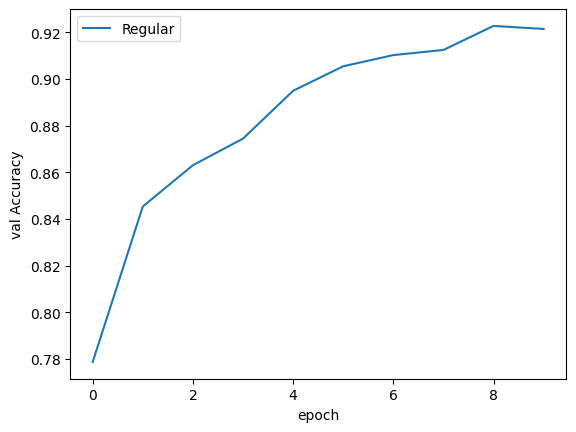

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')

In [ ]:
class Flatten2(nn.Module):
    """
    Takes a vector of shape (A, B, C, D, E, ...)
    and flattens everything but the first two dimensions,
    giving a result of shape (A, B, C*D*E*...)
    e.g., a bag of images (B,T,C,W,H) to a bag of feature vectors (B,T,C*W*H)
    """
    def forward(self, input):
        return input.view(input.size(0), input.size(1), -1)

### Attention Mechanism

$\mathbf{\alpha} = sm(\underbrace{\text{score}(\overbrace{F(\mathbf{x_1})}^{h_1}}_{\tilde{\alpha}_1}, \text{score}(F(\mathbf{x_2})), \ldots, \text{score}(F(\mathbf{x_T})))$

$\bar{\mathbf{x}} = \sum_{i=1}^T\alpha_i \cdot \underbrace{F(\mathbf{x_i})}_{h_i}$

1. **Attention Weights Calculation**:
   $$
   \mathbf{\alpha} = \text{sm}(\underbrace{\text{score}(\overbrace{F(\mathbf{x_1})}^{h_1})}_{\tilde{\alpha}_1}, \text{score}(F(\mathbf{x_2})), \ldots, \text{score}(F(\mathbf{x_T})))
   $$
   - $ \mathbf{x_1}, \mathbf{x_2}, \ldots, \mathbf{x_T} $ are input vectors, where $ T $ is the number of time steps or elements in the sequence.
   - $ F $ is a function that transforms each input $ \mathbf{x_i} $ into a hidden representation $ h_i $. For example, $ F $ could be a neural network layer.
$$
     h_i = F(\mathbf{x_i})
$$
   - $ \text{score}(F(\mathbf{x_i})) $ is a function that computes a score for each hidden representation $ h_i $. This score reflects the importance or relevance of $ h_i $.
   - $ \text{sm} $ represents the softmax function, which converts the scores into a probability distribution, resulting in the attention weights $ \alpha_i $. The softmax function ensures that the weights are non-negative and sum to 1.

   The attention weights $ \alpha $ can be expressed as:
   $$
   \alpha_i = \frac{\exp(\text{score}(h_i))}{\sum_{j=1}^T \exp(\text{score}(h_j))}
   $$

2. **Weighted Sum of Representations**:
   $$
   \bar{\mathbf{x}} = \sum_{i=1}^T \alpha_i \cdot \underbrace{F(\mathbf{x_i})}_{h_i}
   $$
   - $ \bar{\mathbf{x}} $ is the weighted sum of the hidden representations $ h_i $.
   - Each hidden representation $ h_i $ is weighted by its corresponding attention weight $ \alpha_i $.
   - The resulting $ \bar{\mathbf{x}} $ is a context vector that aggregates information from all the input vectors, emphasizing the most relevant parts according to the attention weights.

In summary, the attention mechanism allows the model to focus on specific parts of the input sequence when constructing the context vector $ \bar{\mathbf{x}} $. The scores computed for each hidden representation determine the attention weights, which are then used to compute a weighted sum of the hidden representations, resulting in $ \bar{\mathbf{x}} $. This context vector $ \bar{\mathbf{x}} $ can then be used for further processing, such as making predictions or generating outputs.

The Combiner class is designed to integrate a feature extraction network (featureExtraction) and a weight selection network (weightSelection). The class combines the outputs of these networks to produce a weighted sum of features, which acts as a context vector.

- featureExtraction: A network that transforms the input into a new representation.
- weightSelection: A network that assigns importance weights to each feature in the sequence.
- forward method:
  - Extracts features from the input.
  - Computes importance weights for these features.
  - Multiplies features by their corresponding weights.
  - Sums the weighted features along the sequence dimension to produce a context vector.

In [ ]:
class Combiner(nn.Module):
    """
    This class is used to combine a feature extraction network F and a importance prediction network W,
    and combine their outputs by adding and summing them together.
    """

    def __init__(self, featureExtraction, weightSelection):
        """
        featureExtraction: a network that takes an input of shape (B, T, D) and outputs a new
            representation of shape (B, T, D').
        weightSelection: a network that takes in an input of shape (B, T, D') and outputs a
            tensor of shape (B, T, 1) or (B, T). It should be normalized, so that the T
            values at the end sum to one (torch.sum(_, dim=1) = 1.0)
        """
        super(Combiner, self).__init__()
        self.featureExtraction = featureExtraction
        self.weightSelection = weightSelection

    def forward(self, input):
        """
        input: a tensor of shape (B, T, D)
        return: a new tensor of shape (B, D')
        """
        features = self.featureExtraction(input) #(B, T, D) $\boldsymbol{h}_i = F(\boldsymbol{x}_i)$
        weights = self.weightSelection(features) #(B, T) or (B, T, 1) for $\boldsymbol{\alpha}$
        if len(weights.shape) == 2: #(B, T) shape
            weights.unsqueese(2) #now (B, T, 1) shape

        r = features*weights #(B, T, D), computes $\alpha_i \cdot \boldsymbol{h}_i$

        return torch.sum(r, dim=1) #sum over the T dimension, giving (B, D) final shape $\bar{\boldsymbol{x}}$

In [ ]:
T = 3 # number of items in our bag
D = 784 # number of features

The backboneNetwork is responsible for transforming the input data into a feature representation.

In [ ]:
backboneNetwork = nn.Sequential(
    Flatten2(),# Shape is now (B, T, D)
    nn.Linear(D,neurons), #Shape becomes (B, T, neurons)
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(), #still (B, T, neurons) on the way out
)

The attentionMechanism network assigns importance weights to each feature in the sequence. Can be relatively small, assuming backbone has done most of the work.

In [ ]:
attentionMechanism = nn.Sequential(
    #Shape is (B, T, neurons)
    nn.Linear(neurons,neurons),
    nn.LeakyReLU(),
    nn.Linear(neurons, 1 ), # (B, T, 1), a single weight per feature
    nn.Softmax(dim=1), # normalizes weights to sum to 1
)

The final model integrates the Combiner, feature extraction, and attention networks. It then adds additional layers for classification.

Let's break down the mathematical formulation of the `simpleAttentionNet` step by step, incorporating each component and its corresponding operations.

### Notations
- $ \mathbf{x} \in \mathbb{R}^{B \times T \times D} $: Input tensor, where $ B $ is the batch size, $ T $ is the sequence length (number of timesteps), and $ D $ is the input feature dimension.
- $ \mathbf{h}_i $: Hidden representation of the $i$-th input in the sequence.
- $ \alpha_i $: Attention weight for the $i$-th input in the sequence.
- $ \bar{\mathbf{x}} $: Context vector, a weighted sum of hidden representations.
- $ F $: Feature extraction network.
- $ W $: Weight selection (attention) network.
- $ C $: Number of classes for classification.

### Components

#### 1. Feature Extraction Network ($ F $)

The feature extraction network transforms the input tensor $ \mathbf{x} $ into hidden representations $ \mathbf{h} $:

$$
\mathbf{h} = F(\mathbf{x})
$$

Given the structure of `backboneNetwork`, this transformation can be detailed as:

1. **Flatten**: Reshape each input from $ \mathbf{x} \in \mathbb{R}^{B \times T \times D} $ to a flattened vector.
2. **Linear Transformations and Activations**:
   $$
   \mathbf{h}_i = \text{LeakyReLU}(\mathbf{W}_{3} \cdot \text{LeakyReLU}(\mathbf{W}_{2} \cdot \text{LeakyReLU}(\mathbf{W}_{1} \cdot \mathbf{x}_i + \mathbf{b}_{1}) + \mathbf{b}_{2}) + \mathbf{b}_{3})
   $$

   Here, $ \mathbf{W}_1 $, $ \mathbf{W}_2 $, and $ \mathbf{W}_3 $ are weight matrices, and $ \mathbf{b}_1 $, $ \mathbf{b}_2 $, and $ \mathbf{b}_3 $ are bias vectors.

#### 2. Attention Mechanism ($ W $)

The attention mechanism computes the importance weights $ \alpha_i $ for each hidden representation:

$$
\alpha_i = \text{Softmax}(\mathbf{v}_i)
$$

where

$$
\mathbf{v}_i = \mathbf{W}_{5} \cdot \text{LeakyReLU}(\mathbf{W}_{4} \cdot \mathbf{h}_i + \mathbf{b}_{4}) + \mathbf{b}_{5}
$$

Here, $ \mathbf{W}_{4} $ and $ \mathbf{W}_{5} $ are weight matrices, and $ \mathbf{b}_{4} $ and $ \mathbf{b}_{5} $ are bias vectors. The output $ \mathbf{v}_i $ is then passed through a softmax function to obtain normalized attention weights.

#### 3. Combining Features and Weights

The context vector $ \bar{\mathbf{x}} $ is computed as a weighted sum of the hidden representations:

$$
\bar{\mathbf{x}} = \sum_{i=1}^T \alpha_i \mathbf{h}_i
$$

#### 4. Classification Layers

The context vector $ \bar{\mathbf{x}} $ is passed through additional linear layers with batch normalization and activation functions to produce the final output $ \mathbf{y} $:

$$
\mathbf{y} = \mathbf{W}_{8} \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_{7} \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_{6} \cdot \bar{\mathbf{x}} + \mathbf{b}_{6}) + \mathbf{b}_{7}) + \mathbf{b}_{8})
$$

Here, $ \mathbf{W}_{6} $, $ \mathbf{W}_{7} $, and $ \mathbf{W}_{8} $ are weight matrices, and $ \mathbf{b}_{6} $, $ \mathbf{b}_{7} $, and $ \mathbf{b}_{8} $ are bias vectors.

### Overall Formulation

Combining all these components, the mathematical formulation of `simpleAttentionNet` is:

1. **Feature Extraction**:
   $$
   \mathbf{h}_i = F(\mathbf{x}_i)
   $$

2. **Attention Weights**:
   $$
   \alpha_i = \text{Softmax}(\mathbf{W}_{5} \cdot \text{LeakyReLU}(\mathbf{W}_{4} \cdot \mathbf{h}_i + \mathbf{b}_{4}) + \mathbf{b}_{5})
   $$

3. **Context Vector**:
   $$
   \bar{\mathbf{x}} = \sum_{i=1}^T \alpha_i \mathbf{h}_i
   $$

4. **Classification**:
   $$
   \mathbf{y} = \mathbf{W}_{8} \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_{7} \cdot \text{BatchNorm}(\text{LeakyReLU}(\mathbf{W}_{6} \cdot \bar{\mathbf{x}} + \mathbf{b}_{6}) + \mathbf{b}_{7}) + \mathbf{b}_{8})
   $$

Here, $ \mathbf{y} \in \mathbb{R}^{B \times C} $ is the final output of the network, where $ C $ is the number of classes for classification.

Again, the backboe does much of the work, so what's after can be relatively shallower

In [ ]:
simpleAttentionNet = nn.Sequential(
        #input is (B, T, C, W, H). backbone & attention will be used by combiner to process
        Combiner(backboneNetwork, attentionMechanism), # result is (B, neurons)
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons,neurons),
        nn.LeakyReLU(),
        nn.BatchNorm1d(neurons),
        nn.Linear(neurons, classes )
    )
simple_attn_results = train_network(simpleAttentionNet, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader, epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

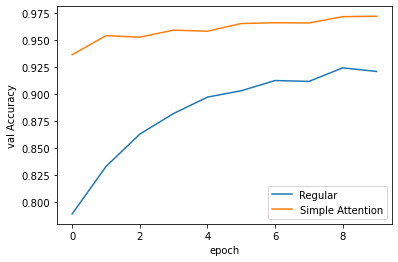

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_attn_results, label='Simple Attention')

In [ ]:
set_seed(1)

The below chunk plots a random bag and its attention weights. All the attention is on the largest digit. This approach thus far is limited, though, because the score is applied indendently to the inputs! Adding context means score for one item depends on all the other items

True Label is =  9


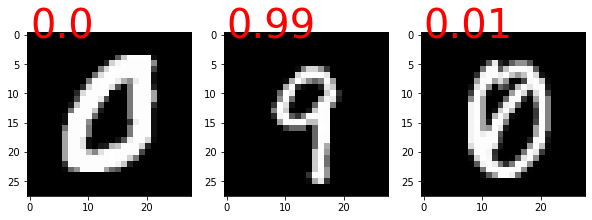

In [ ]:
x, y = largest_train[0] # Select a data point (which is a bag)
x = x.to(device) #move it to the compute device

with torch.no_grad():
    weights = attentionMechanism(backboneNetwork(x.unsqueeze(0))) #apply score(F(x))
    weights = weights.cpu().numpy().ravel() #convert to numpy array

f, axarr = plt.subplots(1,3, figsize=(10,10))#make a plot for all 3 digits
for i in range(3):
    axarr[i].imshow(x[i,0,:].cpu().numpy(), cmap='gray', vmin=0, vmax=1) # Plot the digit
    axarr[i].text(0.0, 0.5, str(round(weights[i],2)), dict(size=40, color='red')) #Draw the attention score in the top left

print("True Label is = ", y)

We want to use global information (context) to inform local decisions (weights $\alpha$). As such, our score function no longer takes a feature vector $h$, but the feature vector with something else (e.g., an average of the feature vectors, score(h) -> score(h, h_bar))

$\underbrace{\bar{h}}_{\text{context}} = \frac{1}{T} \sum_{i=1}^{T}\underbrace{F(x_i)}_{h_i}$

$\alpha = \text{sm}(\text{score}(h_1, \bar{h}),\text{score}(h_2, \bar{h}),\ldots,\text{score}(h_T, \bar{h}))$

$\bar{\mathbf{x}} = \sum_{i=1}^T \alpha_i \mathbf{h}_i$

There are a couple ways to define score()

### Dot Score

$\text{score}(h_t, \bar{h}) = \frac{h_t^\top\bar{h}}{\sqrt{H}}, \text{ where } H = \text{dimension of vectors}$

Orthogonal vectors have no relationship <-> dot product is 0

Less orthogonal <-> larger dot product

Divide to avoid vanishing gradients after softmax computation

In [ ]:
class DotScore(nn.Module):

    def __init__(self, H):
        """
        H: the number of dimensions coming into the dot score.
        """
        super(DotScore, self).__init__()
        self.H = H

    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context

        """
        T = states.size(1)
        #compute $score(\boldsymbol{h}_t^\top, \bar{\boldsymbol{h}})$
        scores = torch.bmm(states,context.unsqueeze(2)) / np.sqrt(self.H) #(B, T, H) -> (B, T, 1), batch multiply computes scores for all T at once
        return scores

One of the features in $\bar{h}$ may not be important, thus the General score was derived to learn weights between the dot product of feature vectors and "context" feature vector

$\text{score}(h_t, \bar{h}) = h_t^\top W_{H \times H} \bar{h}$

Generalizes dot score, reduces to dot score when $W_{H \times H} = I_{H \times H}$

This implementation is a bilinear relationship. These relationships look like
$x_1^\top W x_2 + b$. Can compute with `nn.Bilinear`.

Sometimes dot does better than general, sometimes vice versa.

In [ ]:
class GeneralScore(nn.Module):

    def __init__(self, H):
        """
        H: the number of dimensions coming into the dot score.
        """
        super(GeneralScore, self).__init__()
        self.w = nn.Bilinear(H, H, 1) #stores $W$

    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context

        """
        T = states.size(1)
        #Repeating the values T times
        context = torch.stack([context for _ in range(T)], dim=1) #(B, H) -> (B, T, H)
        #computes $\boldsymbol{h}_{t}^{\top} W \bar{\boldsymbol{h}}$
        scores = self.w(states, context) #(B, T, H) -> (B, T, 1)
        return scores

### Additive (Concat) Attention

$\text{score}(h_t, \bar{h}) = \underbrace{v^\top}_{\text{nn.Linear(H,1)}} \text{tanh}\left(\overbrace{W\left[\underbrace{h_t;\bar{h}}_{\text{torch.cat((}h_t, \bar{h}),\text{dim=1})}\right]}^{\text{nn.Linear(2*H,H)}}\right)$

In [ ]:
class AdditiveAttentionScore(nn.Module):

    def __init__(self, H):
        super(AdditiveAttentionScore, self).__init__()
        self.v = nn.Linear(H, 1)
        self.w = nn.Linear(2*H, H)#2*H because we are going to concatenate two inputs

    def forward(self, states, context):
        """
        states: (B, T, H) shape
        context: (B, H) shape
        output: (B, T, 1), giving a score to each of the T items based on the context

        """
        T = states.size(1)
        #Repeating the values T times
        context = torch.stack([context for _ in range(T)], dim=1) #(B, H) -> (B, T, H), stack T copies
        state_context_combined = torch.cat((states, context), dim=2) #(B, T, H) + (B, T, H)  -> (B, T, 2*H), context features appended to individual features
        scores = self.v(torch.tanh(self.w(state_context_combined))) # (B, T, 2*H) -> (B, T, 1), single linear output for each T.
        return scores

In [ ]:
class ApplyAttention(nn.Module):
    """
    This helper module is used to apply the results of an attention mechanism toa set of inputs.
    """

    def __init__(self):
        super(ApplyAttention, self).__init__()

    def forward(self, states, attention_scores, mask=None):
        """
        states: (B, T, H) shape giving the T different possible inputs
        attention_scores: (B, T, 1) score for each item at each context
        mask: None if all items are present. Else a boolean tensor of shape
            (B, T), with `True` indicating which items are present / valid.

        returns: a tuple with two tensors. The first tensor is the final context
        from applying the attention to the states (B, H) shape. The second tensor
        is the weights for each state with shape (B, T, 1).
        """

        if mask is not None:
            #set everything not present to a large negative value that will cause vanishing gradients
            attention_scores[~mask] = -1000.0
        #compute the weight for each score
        weights = F.softmax(attention_scores, dim=1) #(B, T, 1) still, but sum(T) = 1

        final_context = (states*weights).sum(dim=1) #(B, T, D) * (B, T, 1) -> (B, D)
        return final_context, weights

Masking is often used with attention

In [ ]:
def getMaskByFill(x, time_dimension=1, fill=0):
    """
    x: the original input with three or more dimensions, (B, ..., T, ...)
        which may have unsued items in the tensor. B is the batch size,
        and T is the time dimension.
    time_dimension: the axis in the tensor `x` that denotes the time dimension
    fill: the constant used to denote that an item in the tensor is not in use,
        and should be masked out (`False` in the mask).

    return: A boolean tensor of shape (B, T), where `True` indicates the value
        at that time is good to use, and `False` that it is not.
    """
    to_sum_over = list(range(1,len(x.shape))) #skip the first dimension 0 because that is the batch dimension

    if time_dimension in to_sum_over:
        to_sum_over.remove(time_dimension)

    with torch.no_grad():
        #(x!=fill) determines locations that might be unused, beause they are
        #missing the fill value we are looking for to indicate lack of use.
        #We then count the number of non-fill values over everything in that
        #time slot (reducing changes the shape to (B, T)). If any one entry
        #is non equal to this value, the item represent must be in use -
        #so return a value of true.
        mask = torch.sum((x != fill), dim=to_sum_over) > 0
    return mask

An example of using the Masking function

In [ ]:
with torch.no_grad():
    x = torch.rand((5,3,1,7,7))
    x[0,-1,:] = 0 #Don't use the last item in the first input
    x[3,:] = 0 #Don't use any of the 4'th item!
    x[4,0,0,0] = 0 #Make it _look_ like we aren't using part of the 5th, but we still are!
    #This last line was added to show that this works even on tricky inputs

    mask = getMaskByFill(x)
print(mask)

tensor([[ True,  True, False],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False, False],
        [ True,  True,  True]])


In [ ]:
class SmarterAttentionNet(nn.Module):

    def __init__(self, input_size, hidden_size, out_size, score_net=None):
        super(SmarterAttentionNet, self).__init__()
        self.backbone = nn.Sequential( # computes feature vector h
            Flatten2(),# Shape is now (B, T, D)
            nn.Linear(input_size,hidden_size), #Shape becomes (B, T, H)
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
        )#returns (B, T, H)

        #Try changing this and see how the results change!
        self.score_net = AdditiveAttentionScore(hidden_size) if (score_net is None) else score_net

        self.apply_attn = ApplyAttention()

        self.prediction_net = nn.Sequential( #(B, H), context vector x_bar, computes y_hat = f(x_bar)
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size,hidden_size),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_size),
            nn.Linear(hidden_size, out_size ) #(B, H)
        )


    def forward(self, input):

        mask = getMaskByFill(input)

        h = self.backbone(input) #(B, T, D) -> (B, T, H)

        #h_context = torch.mean(h, dim=1)
        #computes torch.mean but ignoring the masked out parts
        #first add together all the valid items
        h_context = (mask.unsqueeze(-1)*h).sum(dim=1)#(B, T, H) -> (B, H)
        #then divide by the number of valid items, pluss a small value incase a bag was all empty
        h_context = h_context/(mask.sum(dim=1).unsqueeze(-1)+1e-10)

        scores = self.score_net(h, h_context) # (B, T, H) , (B, H) -> (B, T, 1)

        final_context, _ = self.apply_attn(h, scores, mask=mask) # (B,H) result shape

        return self.prediction_net(final_context) # (B,H) -> (B,classes)


In [ ]:
attn_dot = SmarterAttentionNet(D, neurons, classes, score_net=DotScore(neurons))
attn_gen = SmarterAttentionNet(D, neurons, classes, score_net=GeneralScore(neurons))
attn_add = SmarterAttentionNet(D, neurons, classes, score_net=AdditiveAttentionScore(neurons))

attn_results_dot = train_network(attn_dot, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
attn_results_gen = train_network(attn_gen, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)
attn_results_add = train_network(attn_add, nn.CrossEntropyLoss(), train_loader, val_loader=test_loader,epochs=epochs, score_funcs={'Accuracy': accuracy_score}, device=device)

<AxesSubplot:xlabel='epoch', ylabel='val Accuracy'>

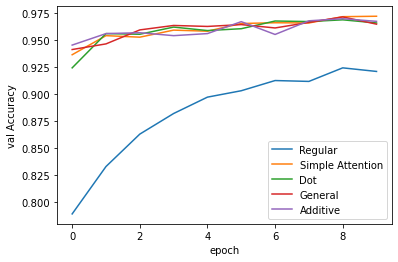

In [ ]:
sns.lineplot(x='epoch', y='val Accuracy', data=simple_results, label='Regular')
sns.lineplot(x='epoch', y='val Accuracy', data=simple_attn_results, label='Simple Attention')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_dot, label='Dot')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_gen, label='General')
sns.lineplot(x='epoch', y='val Accuracy', data=attn_results_add, label='Additive')

In [ ]:
class LargestDigitVariable(Dataset):
    """
    Creates a modified version of a dataset where some variable number of samples are
    taken, and the true label is the largest label sampled. When used with MNIST the
    labels correspond to their values (e.g., digit "6" has label 6). Each datum will
    be padded with 0 values if the maximum number of items was not sampled.
    """

    def __init__(self, dataset, maxToSample=6):
        """
        dataset: the dataset to sample from
        toSample: the number of items from the dataset to sample
        """
        self.dataset = dataset
        self.maxToSample = maxToSample

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):

        #NEW: how many items should we select?
        how_many = np.random.randint(1,self.maxToSample, size=1)[0]
        #Randomly select n=self.toSample items from the dataset
        selected = np.random.randint(0,len(self.dataset), size=how_many)

        #Stack the n items of shape (B, *) shape into (B, n, *)
        #NEW: pad with zero values up to the max size
        x_new = torch.stack([self.dataset[i][0] for i in selected] +
                            [torch.zeros((1,28,28)) for i in range(self.maxToSample-how_many)])
        #Label is the maximum label
        y_new = max([self.dataset[i][1] for i in selected])
        #Return (data, label) pair
        return x_new, y_new

In [ ]:
largestV_train = LargestDigitVariable(mnist_train)
largestV_test = LargestDigitVariable(mnist_test)

trainV_loader = DataLoader(largest_train, batch_size=B, shuffle=True)
testV_loader = DataLoader(largest_test, batch_size=B)

In [ ]:
attn_dot = attn_dot.eval()

preds = []
truths = []
with torch.no_grad():
    for inputs, labels in testV_loader:
        pred = attn_dot(inputs.to(device))
        pred = torch.argmax(pred, dim=1).cpu().numpy()

        preds.extend(pred.ravel())
        truths.extend(labels.numpy().ravel())
print("Variable Length Accuracy: ", accuracy_score(preds, truths))

Variable Length Accuracy:  0.967
